# External images classification

In [22]:
# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!nvcc --version
!nvidia-smi
!pip install cellpose
# import library
from google_drive_downloader import GoogleDriveDownloader as gdd
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install opencv-python-headless==4.1.2.30
import cv2
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from math import ceil, sqrt
import keras
import time, os, sys
from urllib.parse import urlparse
import skimage.io 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse

from cellpose import models, io, core, plot

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat Feb 26 23:00:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    63W / 149W |   5326MiB / 11441MiB |      0%      Default |
|                               |            

# Utils

## Segmentation

In [24]:
def clahe_green(img):  
    # img clahe histogram normalization for low contrast imgs
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
    out = np.copy(img)
    out[:,:,1] = clahe.apply(out[:,:,1])
    return out

def get_cyto_image(img, mask):
    
    # apply equalization to nucleus and cytoplasm separetly
    cyto_img = np.copy(img)
    cyto_img[mask!=0]=0
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
    cyto_img = clahe.apply(cyto_img)
    nuc = np.copy(img)
    nuc[mask==0] = 0
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    nuc = clahe.apply(nuc)
    nuc[mask==0] = 0
    return cyto_img, nuc

def blue_nucleus(img_original, mask):
    # put nucleus in the blue channel and cytoplasm in green
    # return new image
    img = np.copy(img_original)
    cyto_img, nuc = get_cyto_image(img[:, :, 1], mask)
    # put cytoplasm in red channel
    img[:,:,0] = np.zeros(img.shape[:2])
    img[:,:,1] = nuc
    img[:,:,2] = cyto_img
    return img

def apply_nucleus_cellpose(img, name=None, verbose = 0):
    # Apply cell segmentation for nucleus 

    # Params:

    # img - image array
    # name - image name with extention (.jpg), 
    #        should be None if u dont want the image segmentation to be saved
    # verbose - 0 : only segment
    # verbose - 1 : segment and plot
    
    # returns - image with nucleus painted blue, segmented nucleus masks
    channels = [2, 0] # nucleus in channel 2 (green), no cytoplasm (0)
    model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
    img_clean = clahe_green(img)
    masks, flows, _ , _ = model.eval(img_clean, diameter=60, flow_threshold=None, channels=channels)
    
    if verbose == 1:
        fig = plt.figure(figsize=(12,5))
        plot.show_segmentation(fig, img_clean, masks, flows[0], channels=channels, file_name=name)
        plt.tight_layout()
        plt.show()
    img_out = blue_nucleus(img, masks)
    return img_out, masks

def apply_cyto_cellpose(img, d, name=None, verbose = 0):
    # Apply cell segmentation for cytoplasm

    # Params:

    # img - image array
    # name - image name with extention (.jpg), 
    #        should be None if u dont want the image segmentation to be saved
    # verbose - 0 : only segment
    # verbose - 1 : segment and plot
    
    # returns - segmentation masks
    if d>90:
        diameter =145
    else:
        diameter = (145*d)/90
    model = models.Cellpose(gpu=use_GPU, model_type='cyto2')
    # define CHANNELS to run segementation on
    # grayscale=0, R=1, G=2, B=3
    channels = [3, 2] # nucleus in channel 3 (blue), cytoplasm in channel 2 (green)

    masks, flows, _, _ = model.eval(img, diameter=diameter, flow_threshold=None, channels=channels)
    
    if verbose == 1:
        fig = plt.figure(figsize=(12,5))
        plot.show_segmentation(fig, img, masks, flows[0], channels=channels, file_name=name)
        plt.tight_layout()
        plt.show()
    return masks

def exclude_borders(mask):
    # exclude cells broken by borders, and return new mask
    m = np.copy(mask)
    is_border = m != 0
    is_border[1:m.shape[0]-1, 1:m.shape[1]-1] = False
    border_cells = np.unique(m[is_border])
    for i in border_cells:
        m[m==i] = 0
    return m

def apply_mask(img, mask_with_borders, export_G_img=False):
    # Apply mask without borders to image and generate cells
    # Params:

    # img - image array
    # mask_with_borders
    # export_G_img : if true, copy green cell into all channels
    
    # returns - number of cells , cells array
    cells = []
    mask = exclude_borders(mask_with_borders)
    cell_numbers = np.unique(mask)
    cell_numbers = np.delete(cell_numbers, np.where(cell_numbers == 0))
    for i in cell_numbers:
        x, y = np.where(mask==i)
        cell = np.copy(img[np.amin(x):np.amax(x)+1, np.amin(y):np.amax(y)+1])
        cell_mask = mask[np.amin(x):np.amax(x)+1, np.amin(y):np.amax(y)+1]
        for ri in range(cell_mask.shape[0]):
            for ci in range(cell_mask.shape[1]):
                if cell_mask[ri][ci] != i:
                    cell[ri][ci][1] = 0
                    cell[ri][ci][0] = 0
                    cell[ri][ci][2] = 0
        if export_G_img == True:
            cell[:, :, 2] = cell[:, :, 1]
            cell[:, :, 0] = cell[:, :, 1]
            cells.append(cell)
        else:
            cells.append(cell[:,:,1])
    return np.amax(mask)+1, cells

def get_cells_info(cells):
    # gets cells' diameter mean 
    largest_diameter = []
    for img in cells:
        largest_diameter.append(max(img.shape[0], img.shape[1]))
    return np.mean(largest_diameter)

def get_histograms(cells):
    hist_pixel_count = []
    hist_percentage = []
    for img in cells:
        size = img.shape[0]*img.shape[1]
        hist_pixel_count.append(size)
        hist_percentage.append(100*np.count_nonzero(img[:,:]==0)/size)
    return hist_pixel_count, hist_percentage

## Cells preprocessing

In [25]:
def transform_square(X):
  #Images are currently cropped around the cell, this function makes all cells have a black rectangle around them with the same
  #size with the size of their largest dimension
  Xcopy = X.copy()
  for i in range(len(X)):
    #print(i)
    if X[i].shape[0] != X[i].shape[1]:
      max_dimension = max(X[i].shape[0],X[i].shape[1])
      aux = np.zeros((max_dimension, max_dimension))
      if max_dimension == X[i].shape[0]:
        margin = int((max_dimension - X[i].shape[1])/2)
        aux[:, margin: X[i].shape[1]+margin] = X[i]
      else:
        margin = int((max_dimension - X[i].shape[0])/2)
        aux[margin: X[i].shape[0]+margin, :] = X[i]
      Xcopy[i] = aux
  return Xcopy

def standardize_classes(X, y):
  Xcopy = X.copy()
  for i in range(len(y[0])): #iterating between 14 classes
    arr = np.where(y[:, i]==1)[0]
    max_dimension = 0
    for cell in X[arr]: #find the largest dimension in a given class
      max_dimension = max(cell.shape[0], max_dimension)
    for j in arr:
      aux = np.zeros((max_dimension, max_dimension))
      margin = int((max_dimension - X[j].shape[0])/2)
      aux[margin: margin + X[j].shape[0], margin: margin + X[j].shape[0]] = X[j]
      Xcopy[j] = aux
  return Xcopy

def resize_square(X, cnn_input_size, upscaling=False, full_size=True):
  # The resizing implemented is:
    # For smaller cells: no upscaling, just placing a smaller cell in a bigger black square if upscaling is false
      #If upscaling is true, then it upscales
    # for bigger cells: downscaling
  if full_size:
    Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
    for i in range(len(X)):
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
      Xcopy[i] = np.asarray(aux, 'float32')
    return Xcopy
  if upscaling==True:
    X = standardize_classes(X, y)
  Xcopy = np.zeros((len(X), cnn_input_size, cnn_input_size))
  for i in range(len(X)):
    if X[i].shape[0] < cnn_input_size and upscaling==False:
      aux = np.zeros((cnn_input_size, cnn_input_size))
      margin = int((cnn_input_size - X[i].shape[0])/2)
      aux[margin: margin + X[i].shape[0], margin: margin + X[i].shape[0]] = X[i]
    elif X[i].shape[0] >= cnn_input_size or upscaling==True:
      aux = cv2.resize(X[i], dsize=(cnn_input_size, cnn_input_size), interpolation=cv2.INTER_CUBIC)
    Xcopy[i] = np.asarray(aux, 'float16')
  return Xcopy

def grayscale_2_3channel(X):
  #copies grayscale into other channels for VGG
  return np.repeat(np.expand_dims(X, 3), 3, axis=3)
  
def filter_db(X, pixel_count, percentage):
  # returns X and y inside parameters of
  # pixel_count and percentage of empty space
  Xl = []
  for i in range(len(X)):
    size = X[i].shape[0]*X[i].shape[1]
    percent = (100*np.count_nonzero(X[i]==0))/size
    if size < pixel_count[0] and size > pixel_count[1]:
      if percent < percentage[0] and percent > percentage[1]:
        Xl.append(X[i])
  return Xl


def data_preparation (X, hist_pixel_count, hist_percentage, image_reshape_size, filter=False):
  if filter:
    print("Filtering")
    pixel_parameters = get_parameters(hist_pixel_count)
    percentage_parameters = get_parameters(hist_percentage, True)
    X_filtered = filter_db(X, pixel_parameters, percentage_parameters)
  else:
    X_filtered = X
  print('Normalizing images')
  imgs_normalized = normalize(X_filtered)
  print("Making cells square")
  square = transform_square(imgs_normalized)
  print("Resizing to the correct size for classification")
  res_square = resize_square(square, image_reshape_size)
  print("Putting image in 3 channels")
  cells = grayscale_2_3channel(res_square)
  return cells

def normalize(X):
    for idx, img in enumerate(X):
        ar = np.array(img).astype(np.float32)
        mn = np.min(ar)
        mx = np.max(ar)
        X[idx] = (ar - mn) * (1.0 / (mx - mn))
    return X


def get_parameters(hist, percent=False):
  # gets parameters for filtering
  critical1 = np.quantile(hist, 0.9)
  if percent:
    critical2 = np.quantile(hist, 0.1)
  else:
    critical2 = np.quantile(hist, 0.1)
  return np.asarray([int(critical1), int(critical2)])

## Plotting

In [26]:
def cells_plot(X, image_shape, collumn_size):
  count = 0
  limit = collumn_size*(image_shape+2)
  out = np.zeros((2,limit))
  row = np.array([])
  n = 0
  # for every cell in image
  for i, x in enumerate(X):
    if count == 0:
      row = np.c_[x, np.zeros((image_shape,2))]
    else:
      row = np.c_[row, np.c_[x, np.zeros((image_shape,2))]]
    count += 1
    if count == collumn_size:
      n += collumn_size
      out = np.r_[out, np.zeros((2,limit))]
      out = np.r_[out, row]
      row = np.array([])
      count = 0
      if n>collumn_size**2:
        break
  n += count
  if count != 0:
    for i in range(count, collumn_size):
        row = np.c_[row, np.c_[np.zeros((image_shape,image_shape+2))]]
    out = np.r_[out, np.zeros((2,limit))]
    out = np.r_[out, row]
  w, h = out.shape
  output = np.zeros((w, h, 3))
  output[:,:,1] = out
  return output, n

## Multi class

In [27]:
def get_classes_model():
    n_classes = 47
    model = VGG16(include_top=False, input_shape=(image_reshape_size, image_reshape_size, 3), weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu')(flat1)
    class2 = Dense(1024, activation='relu')(class1)
    drop = Dropout(0.5)(class2)
    output = Dense(n_classes, activation='softmax')(drop)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # summarize
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=["accuracy"]) 
    model.summary()
    return model

def classify_cells_multi(X, weight_list, y_pattern_dict):
  n_hep_classes = 47  
  model = get_classes_model()
  model.set_weights(weight_list)
  prediction = np.zeros(n_hep_classes)
  for pred in np.argmax(model.predict(X), axis=1):
    prediction[pred] += 1
  prediction /= X.shape[0] # average
  print(f"Prediction: {y_pattern_dict[np.argmax(prediction)]}")
  idx = (-prediction).argsort()[:5]
  for n, top in enumerate(idx):
    print(f"Top {n+1} Prediction: {y_pattern_dict[int(top)]} - Probability: {prediction[int(top)]:.2f}")

def get_hep_classes(pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells/*'):
    hep_dict = []
    for pattern in sorted(glob.glob(pattern_folder)):
      pattern_name =  pattern[len(pattern_folder)-1:].lower() #Name of pattern
      hep_dict.append(pattern_name)

    return hep_dict

## Multi label

In [28]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras(model):
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass
    try:  
        gc.collect()
        print("Clearing GPU") # if it's done something you should see a number being outputted
    except:
        print("Failed clearing GPU")
    # use the same config as you used to create the session
    config = tensorflow.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.compat.v1.Session(config=config))

def get_multi_label_model():
    model = VGG16(include_top=False, input_shape=(image_reshape_size, image_reshape_size, 3), weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    #class1 = Dense(1024, activation='relu')(flat1)
    class2 = Dense(512, activation='relu')(flat1)
    class3 = Dense(256, activation='relu')(class2)
    drop = Dropout(0.3)(class3)
    output = Dense(1, activation='sigmoid')(drop)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # summarize
    METRICS = [
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=METRICS) 
    return model


def classify_cells_label(X, n_primary_classes, weight_list, image_reshape_size, primary_classes, classification_threshold = 0.5):

  # for every cell of X we have n_primary_classes possible pcs
  predictions = np.zeros((X.shape[0], n_primary_classes))
  # pc = primary class 
  model = get_multi_label_model()
  for pc in range(n_primary_classes):
    model.set_weights(weight_list[pc])
    pc_prediction = model.predict(X) > classification_threshold
    predictions[:, pc] = np.ravel(pc_prediction)
    if sum(pc_prediction)>0:


      plot_predictions(X[np.ravel(pc_prediction)==1], image_reshape_size, primary_classes[pc])

  
  # for all images get most probable class
  main_predictions = np.sum(predictions, axis=0)/n_primary_classes 
  
  # print best classes
  get_prediction(main_predictions, primary_classes, n_primary_classes) 


  

def get_prediction(main_predictions, primary_classes, top5=False):
  predicted_classes = np.argsort(-main_predictions)
  print(f"Top Predictions:")
  count = 1
  for i in predicted_classes:
    if main_predictions[i]>0:
      print(f'{count} - {primary_classes[i]}\n')
      count += 1
      if top5==True and count>5:
        break
    else: 
      break


def plot_predictions(x_pred, image_reshape_size, label):
  print(f"Number of cells: {x_pred.shape[0]}")
  col_size = ceil(sqrt(x_pred.shape[0]))
  mozaic , _ = cells_plot(x_pred[:,:,:,0], image_reshape_size, col_size)
  fig = plt.figure(figsize=(10,10))
  plt.imshow(mozaic)
  plt.title(f'Cells classified as {label}')
  plt.show()

def get_primary_classes(pattern_folder = '/content/drive/MyDrive/Images/Cells/Full_image_cells/*'):
    primary_classes = []
    pattern_dict = []
    for pattern in sorted(glob.glob(pattern_folder)):
      pattern_name =  pattern[len(pattern_folder)-1:].lower() #Name of pattern
      pattern_dict.append(pattern_name)
      for pc in pattern_name.split():
        if pc not in primary_classes:
          primary_classes.append(pc)
    
    primary_df = pd.DataFrame(index=primary_classes, columns=pattern_dict)
    for pattern in sorted(glob.glob(pattern_folder)):
      pattern_name =  pattern[len(pattern_folder)-1:].lower() #Name of pattern
      for pc in primary_classes:
        if pc in pattern_name.split():
          primary_df[pattern_name].loc[pc] = 1
        else:
          primary_df[pattern_name].loc[pc] = 0

    return primary_df, primary_classes

# External image import
We use the image of the pattern in folder "Patterns" classified as "Mouchete dot", a class that our training dataset does not have.


In [29]:
image_reshape_size = 96
img_name = '/content/image.jpg'
# we use the file identifier from google drive (see guide for details)
gdd.download_file_from_google_drive(file_id="1_-6agMMTyeR5yWvYAxsb0WJF89eU2Qvw",dest_path = img_name, overwrite=True)
img = cv2.imread(img_name)

# Nucleus segmentation and results
The results of the cell diameter follow these sizes (change notebook to light mode to see image better):

![](https://drive.google.com/uc?export=view&id=1QxjZ9i3WMTdwoH3GgkB0kxVupPZoRaTD)

You can check against the calculated one:

In [30]:
# get mask and img with blue nucleus
img_blue_nucleus, mask = apply_nucleus_cellpose(img, verbose = 1)
# get segmented cells and their number
number_cells, nucleus_cells = apply_mask(img, mask, export_G_img=False)
mean_nucleus_diameter = get_cells_info(nucleus_cells)
print(f'Cells mean nucleus diameter: {mean_nucleus_diameter}')

col_size = ceil(sqrt(number_cells))

Output hidden; open in https://colab.research.google.com to view.

As well as see the segmentation result:

Normalizing images
Making cells square
Resizing to the correct size for classification
Putting image in 3 channels
Number of cells: 58


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


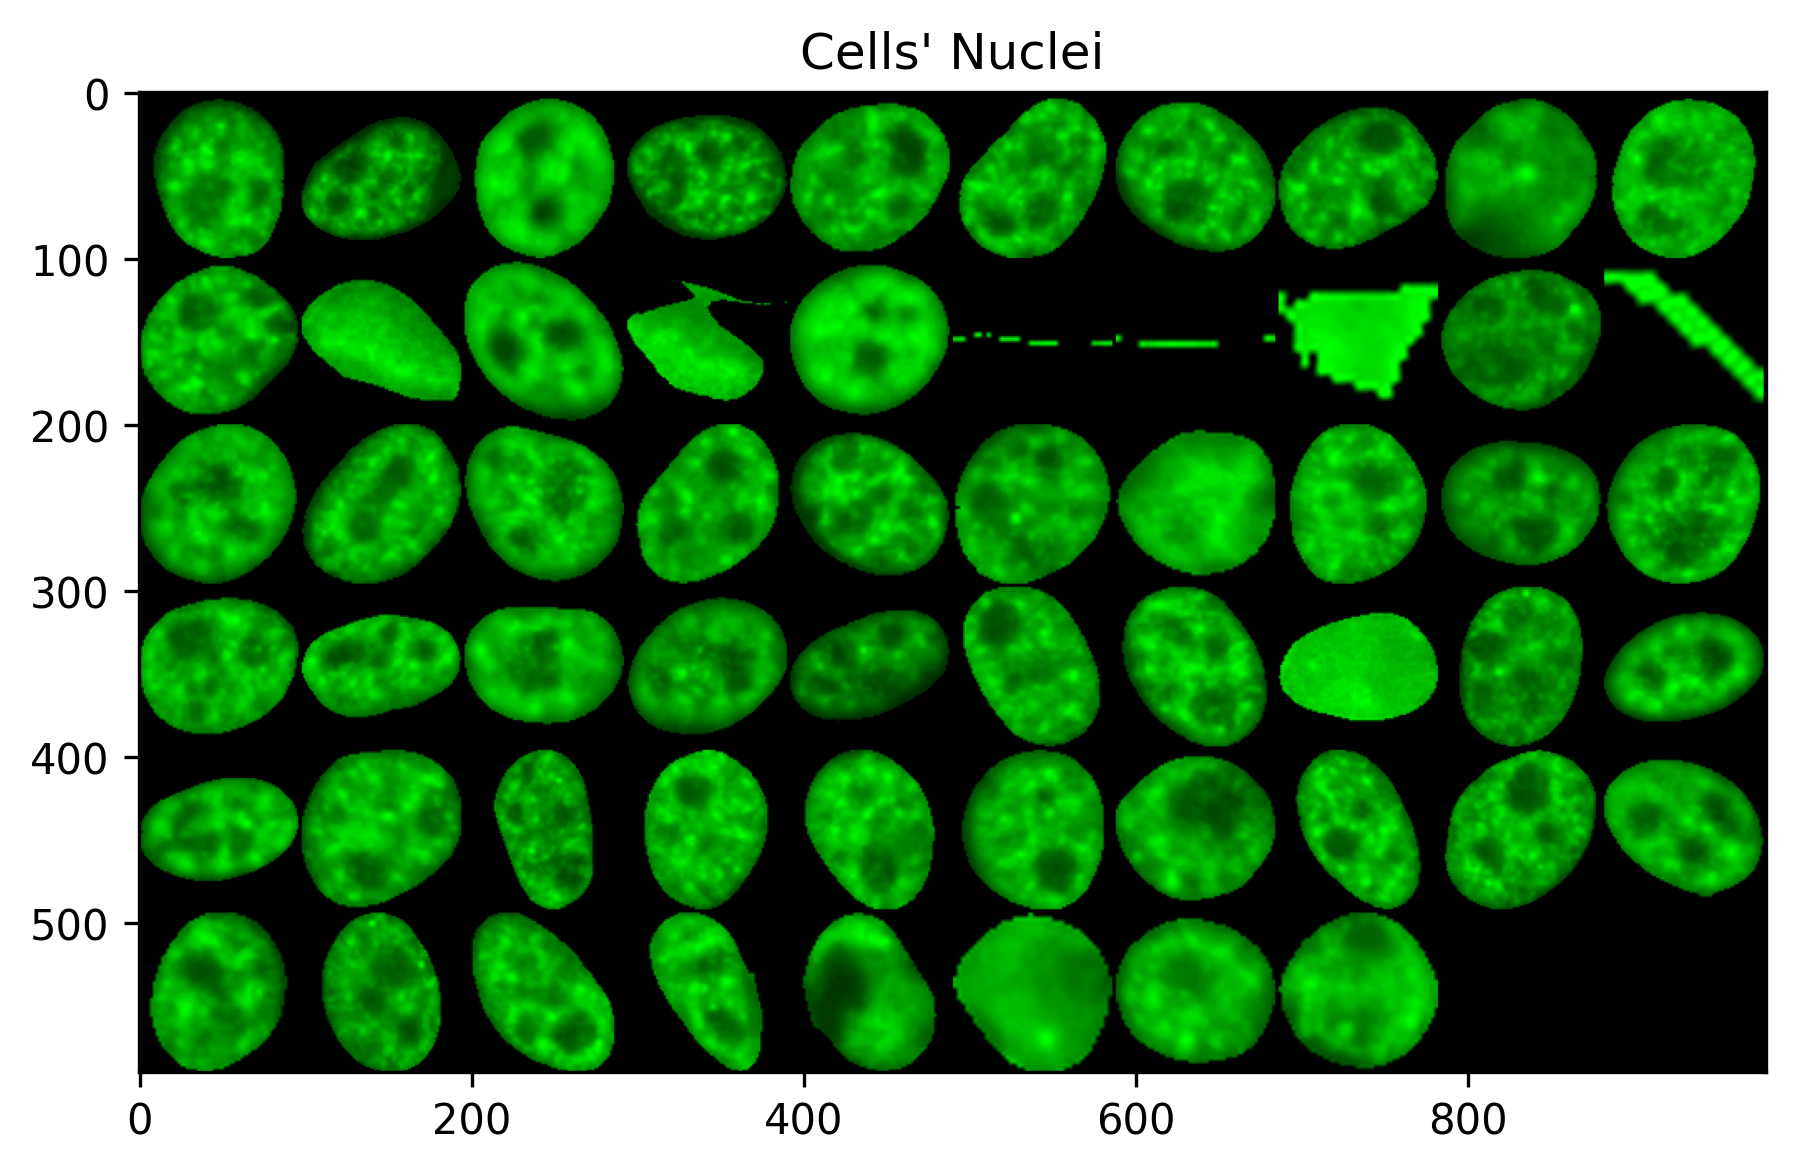

In [38]:
# plot cells with just the nucleus
hist_pixel_count, hist_percentage = get_histograms(nucleus_cells)
square_nucleus = data_preparation (nucleus_cells, hist_pixel_count, hist_percentage, image_reshape_size, filter=False)
mozaic , n = cells_plot(square_nucleus[:,:,:,0], image_reshape_size, col_size)
print(f"Number of cells: {n}")
fig  = plt.figure(figsize=(7,7))
plt.imshow(mozaic)
plt.title(f"Cells' Nuclei")
plt.show()
del mozaic

# Cytoplasm segmentation and results
The results of the cell diameter follow these sizes (change notebook to light mode to see image better):

![](https://drive.google.com/uc?export=view&id=1VKorKKtLeMKGzHUeKOzBbBb1S9cIEL4l)

You can check against the calculated one:

In [32]:
# get mask and img with blue nucleus

mask = apply_cyto_cellpose(img_blue_nucleus, mean_nucleus_diameter, verbose = 1)
# get segmented cells and their number
number_cells, cyto_cells = apply_mask(img, mask, export_G_img=False)
mean_cyto_diameter = get_cells_info(cyto_cells)
print(f'Cells mean cytoplasm diameter: {mean_cyto_diameter}')

col_size = ceil(sqrt(number_cells))

Output hidden; open in https://colab.research.google.com to view.

As well as see the segmentation result:

Normalizing images
Making cells square
Resizing to the correct size for classification
Putting image in 3 channels
Filtering
Normalizing images
Making cells square
Resizing to the correct size for classification
Putting image in 3 channels
Number of cells: 74


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


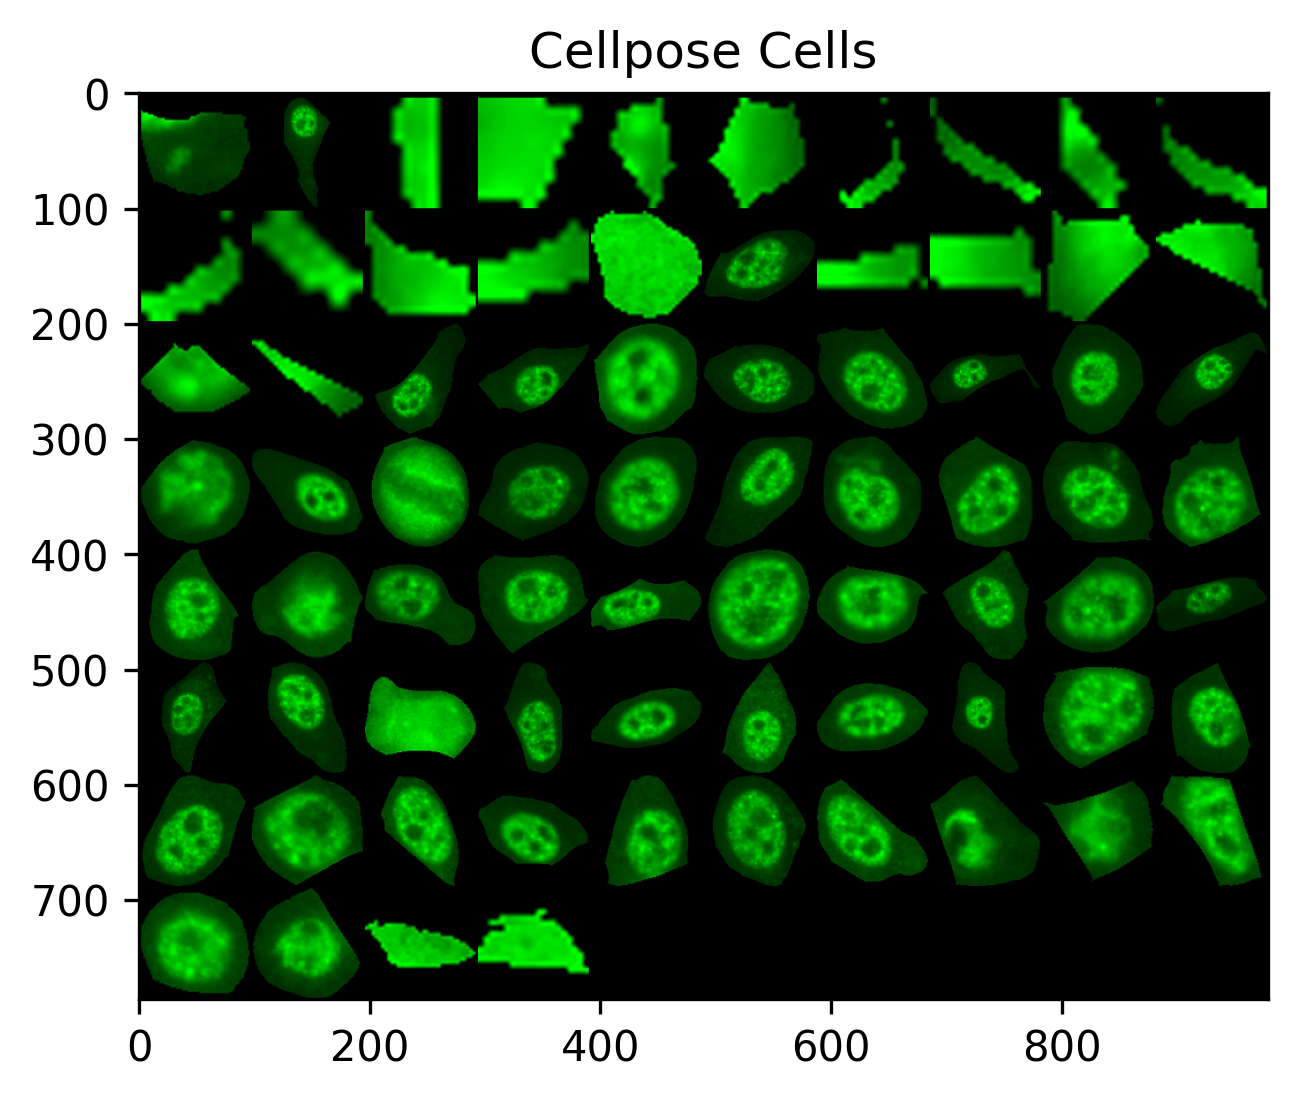

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 49


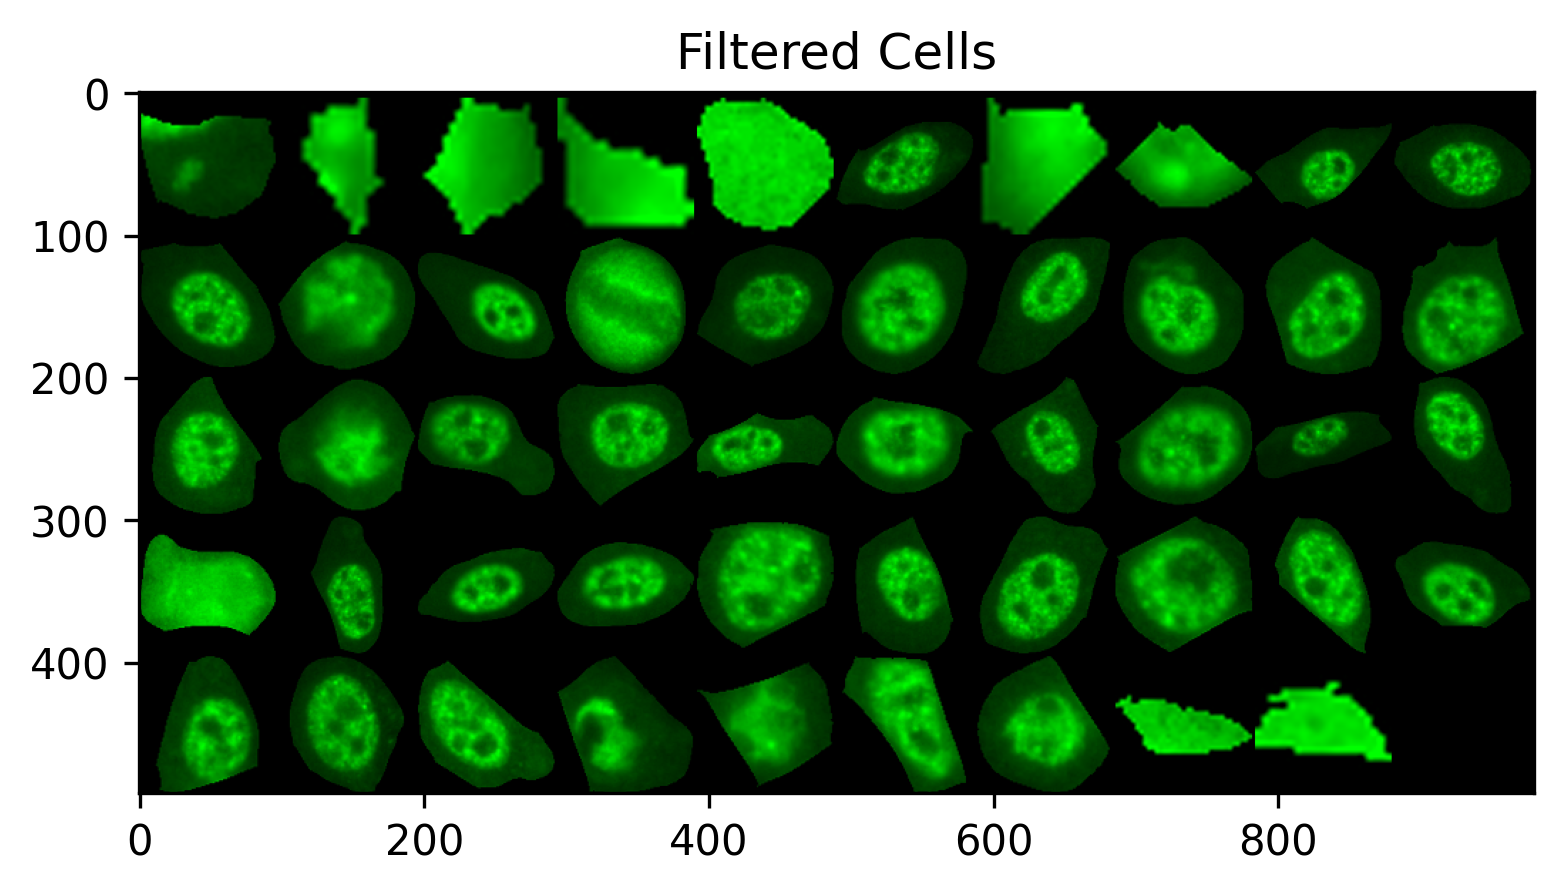

In [33]:
# plot cells with just the nucleus
hist_pixel_count, hist_percentage = get_histograms(cyto_cells)
square_cyto = data_preparation (cyto_cells, hist_pixel_count, hist_percentage, image_reshape_size, filter=False)
square_filtered_cyto = data_preparation (cyto_cells, hist_pixel_count, hist_percentage, image_reshape_size, filter=True)
mozaic , n = cells_plot(square_cyto[:,:,:,0], image_reshape_size, col_size)
print(f"Number of cells: {n}")
plt.imshow(mozaic)
plt.title(f"Cellpose Cells")
plt.show()
del mozaic
mozaic , n = cells_plot(square_filtered_cyto[:,:,:,0], image_reshape_size, col_size)
print(f"Number of cells: {n}")
plt.imshow(mozaic)
plt.title(f"Filtered Cells")
plt.show()
del mozaic

# Multi-class results

In [34]:
print('Geting weights')
weight_dest = '/content/drive/MyDrive/Weights/'
weight_multiclass = np.load(weight_dest+'weight_cnn_hep.npy', allow_pickle= True)
hep_dict = get_hep_classes()

print('Classifying')
classify_cells_multi(square_filtered_cyto, weight_multiclass, hep_dict)

Geting weights
Classifying
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (No

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Trainable params: 5,817,391
Non-trainable params: 14,714,688
_________________________________________________________________
Prediction: mouchete sae1
Top 1 Prediction: mouchete sae1 - Probability: 0.51
Top 2 Prediction: mouchete nxp2 - Probability: 0.08
Top 3 Prediction: mouchete fin - Probability: 0.06
Top 4 Prediction: mouchete dot rnp - Probability: 0.06
Top 5 Prediction: mouchete m0 - Probability: 0.04


# Multi-label results


In [35]:
print('Geting weights')
weight_list = np.load(weight_dest+'multi_label_weights_cnn.npy', allow_pickle= True)
primary_df, primary_classes = get_primary_classes()
n_primary_classes = primary_df.shape[0]


Geting weights


Classifying


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 38


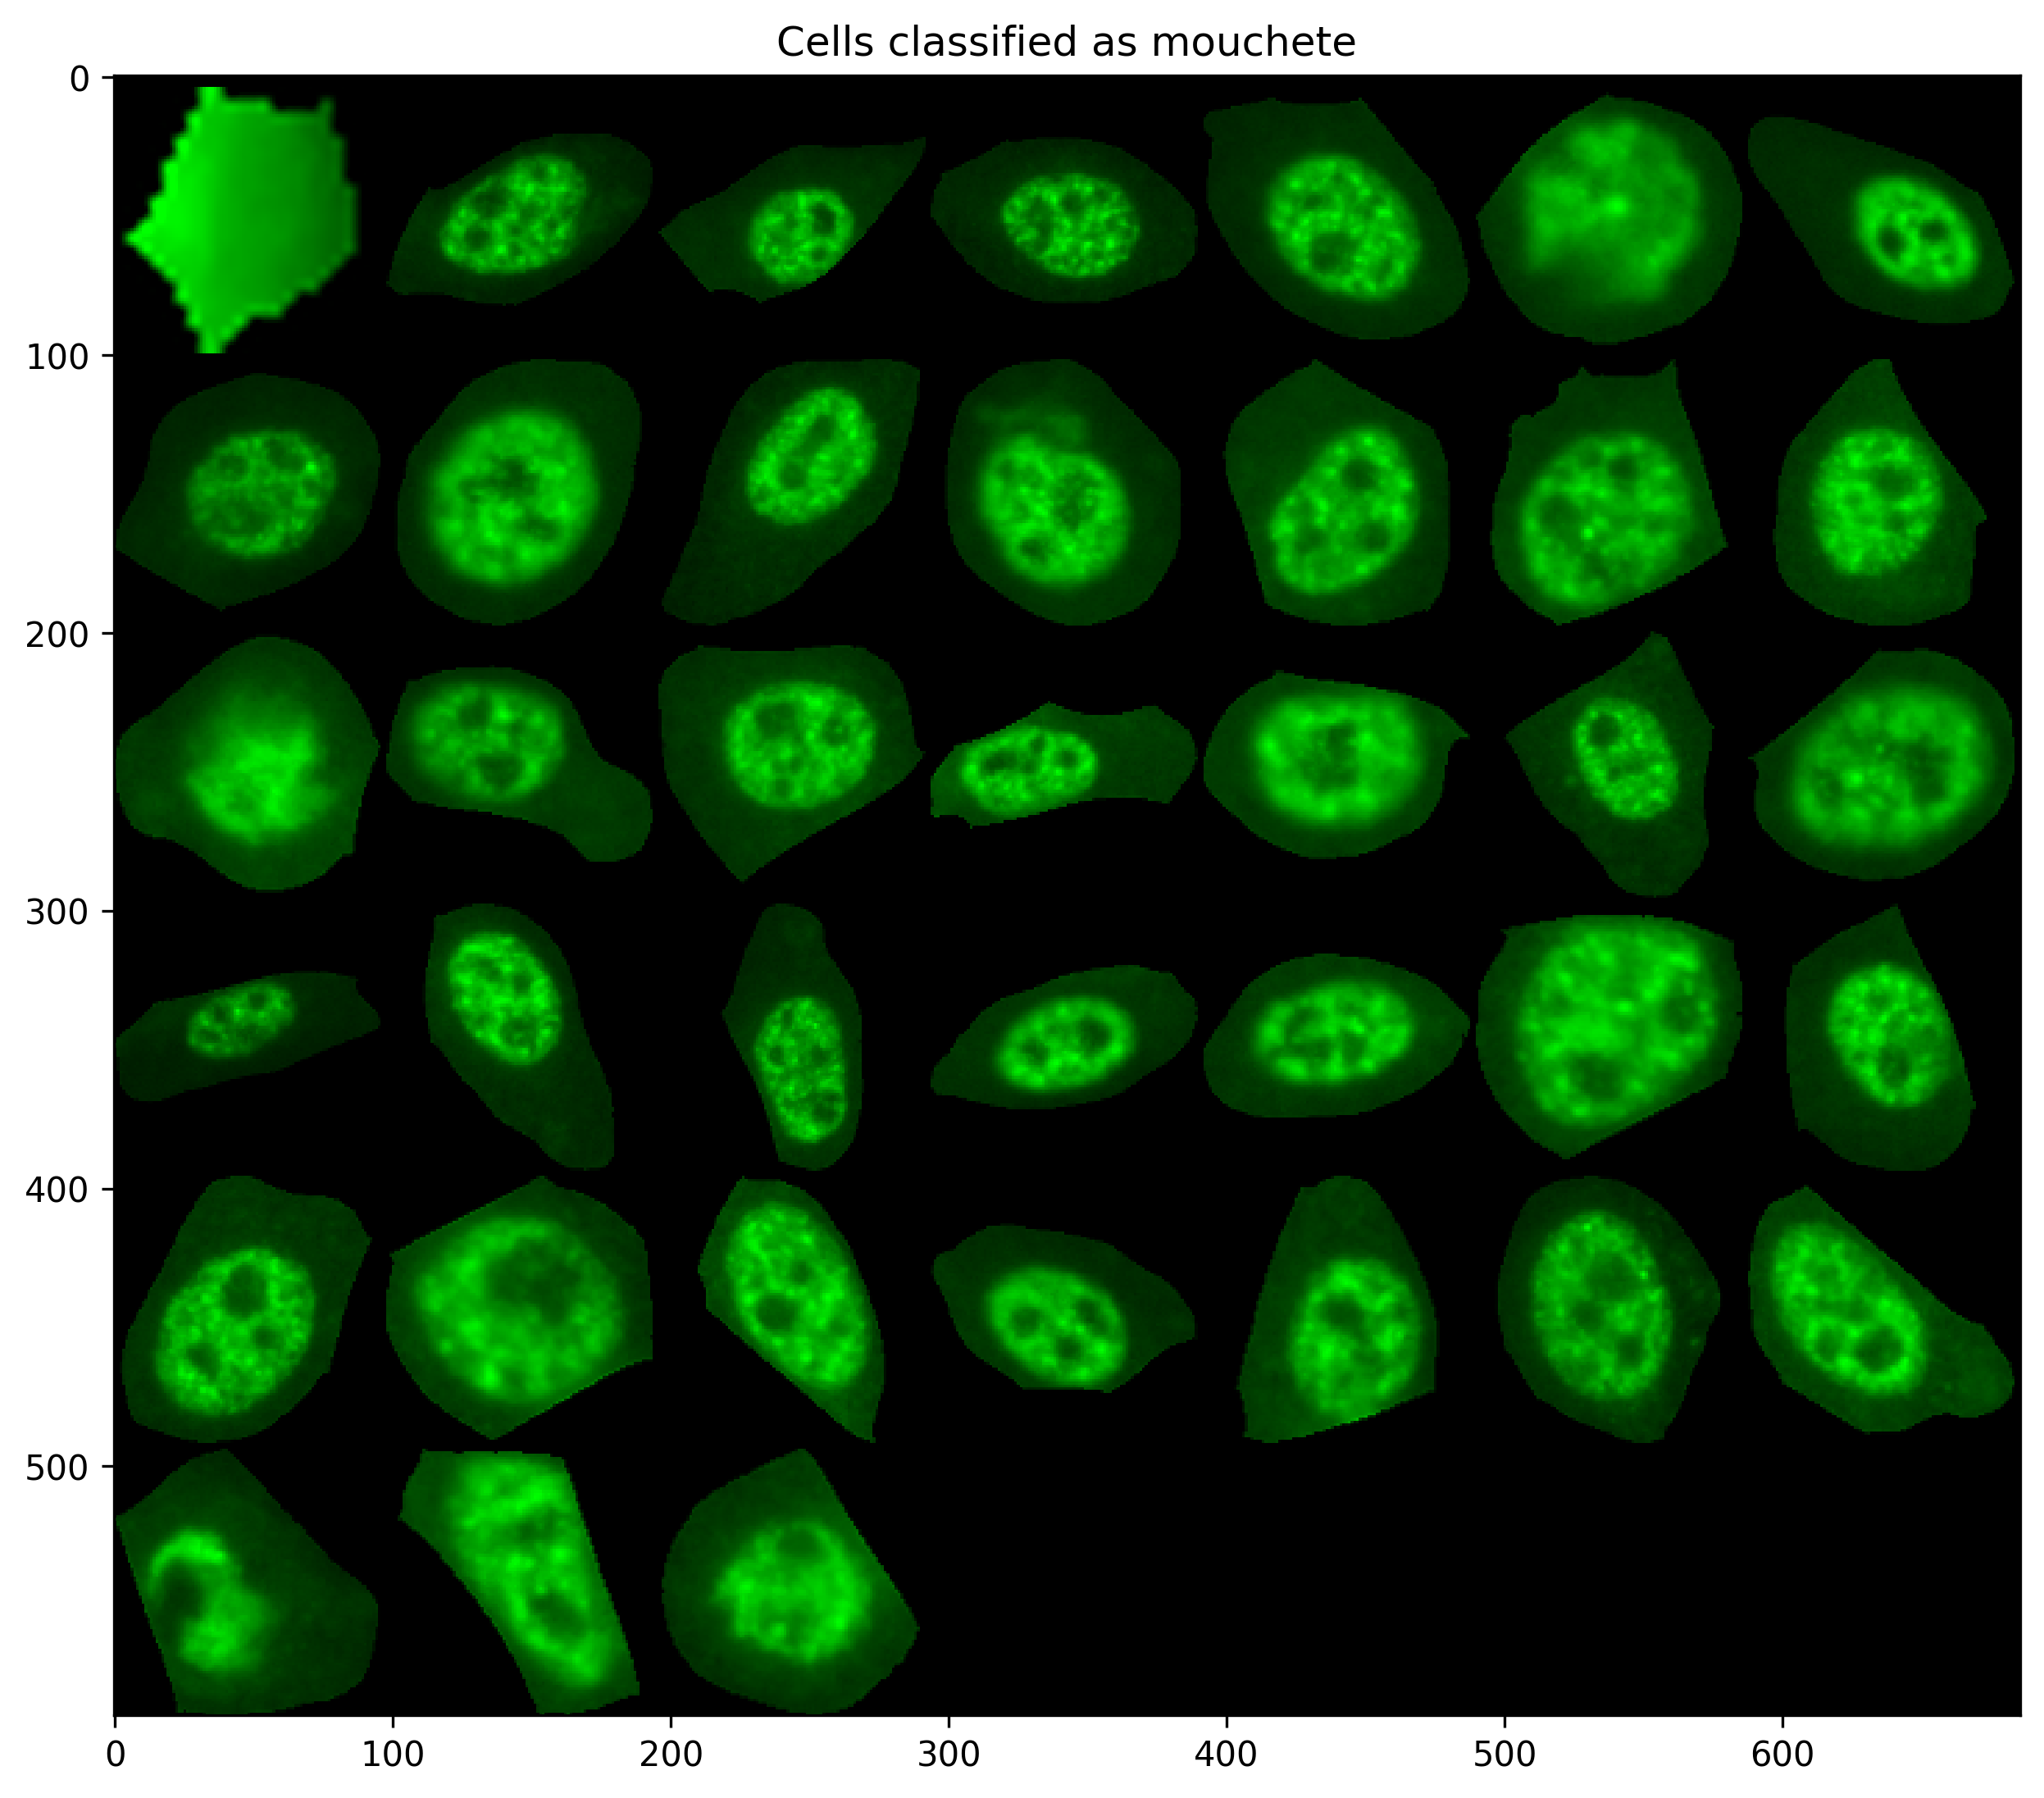

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 1


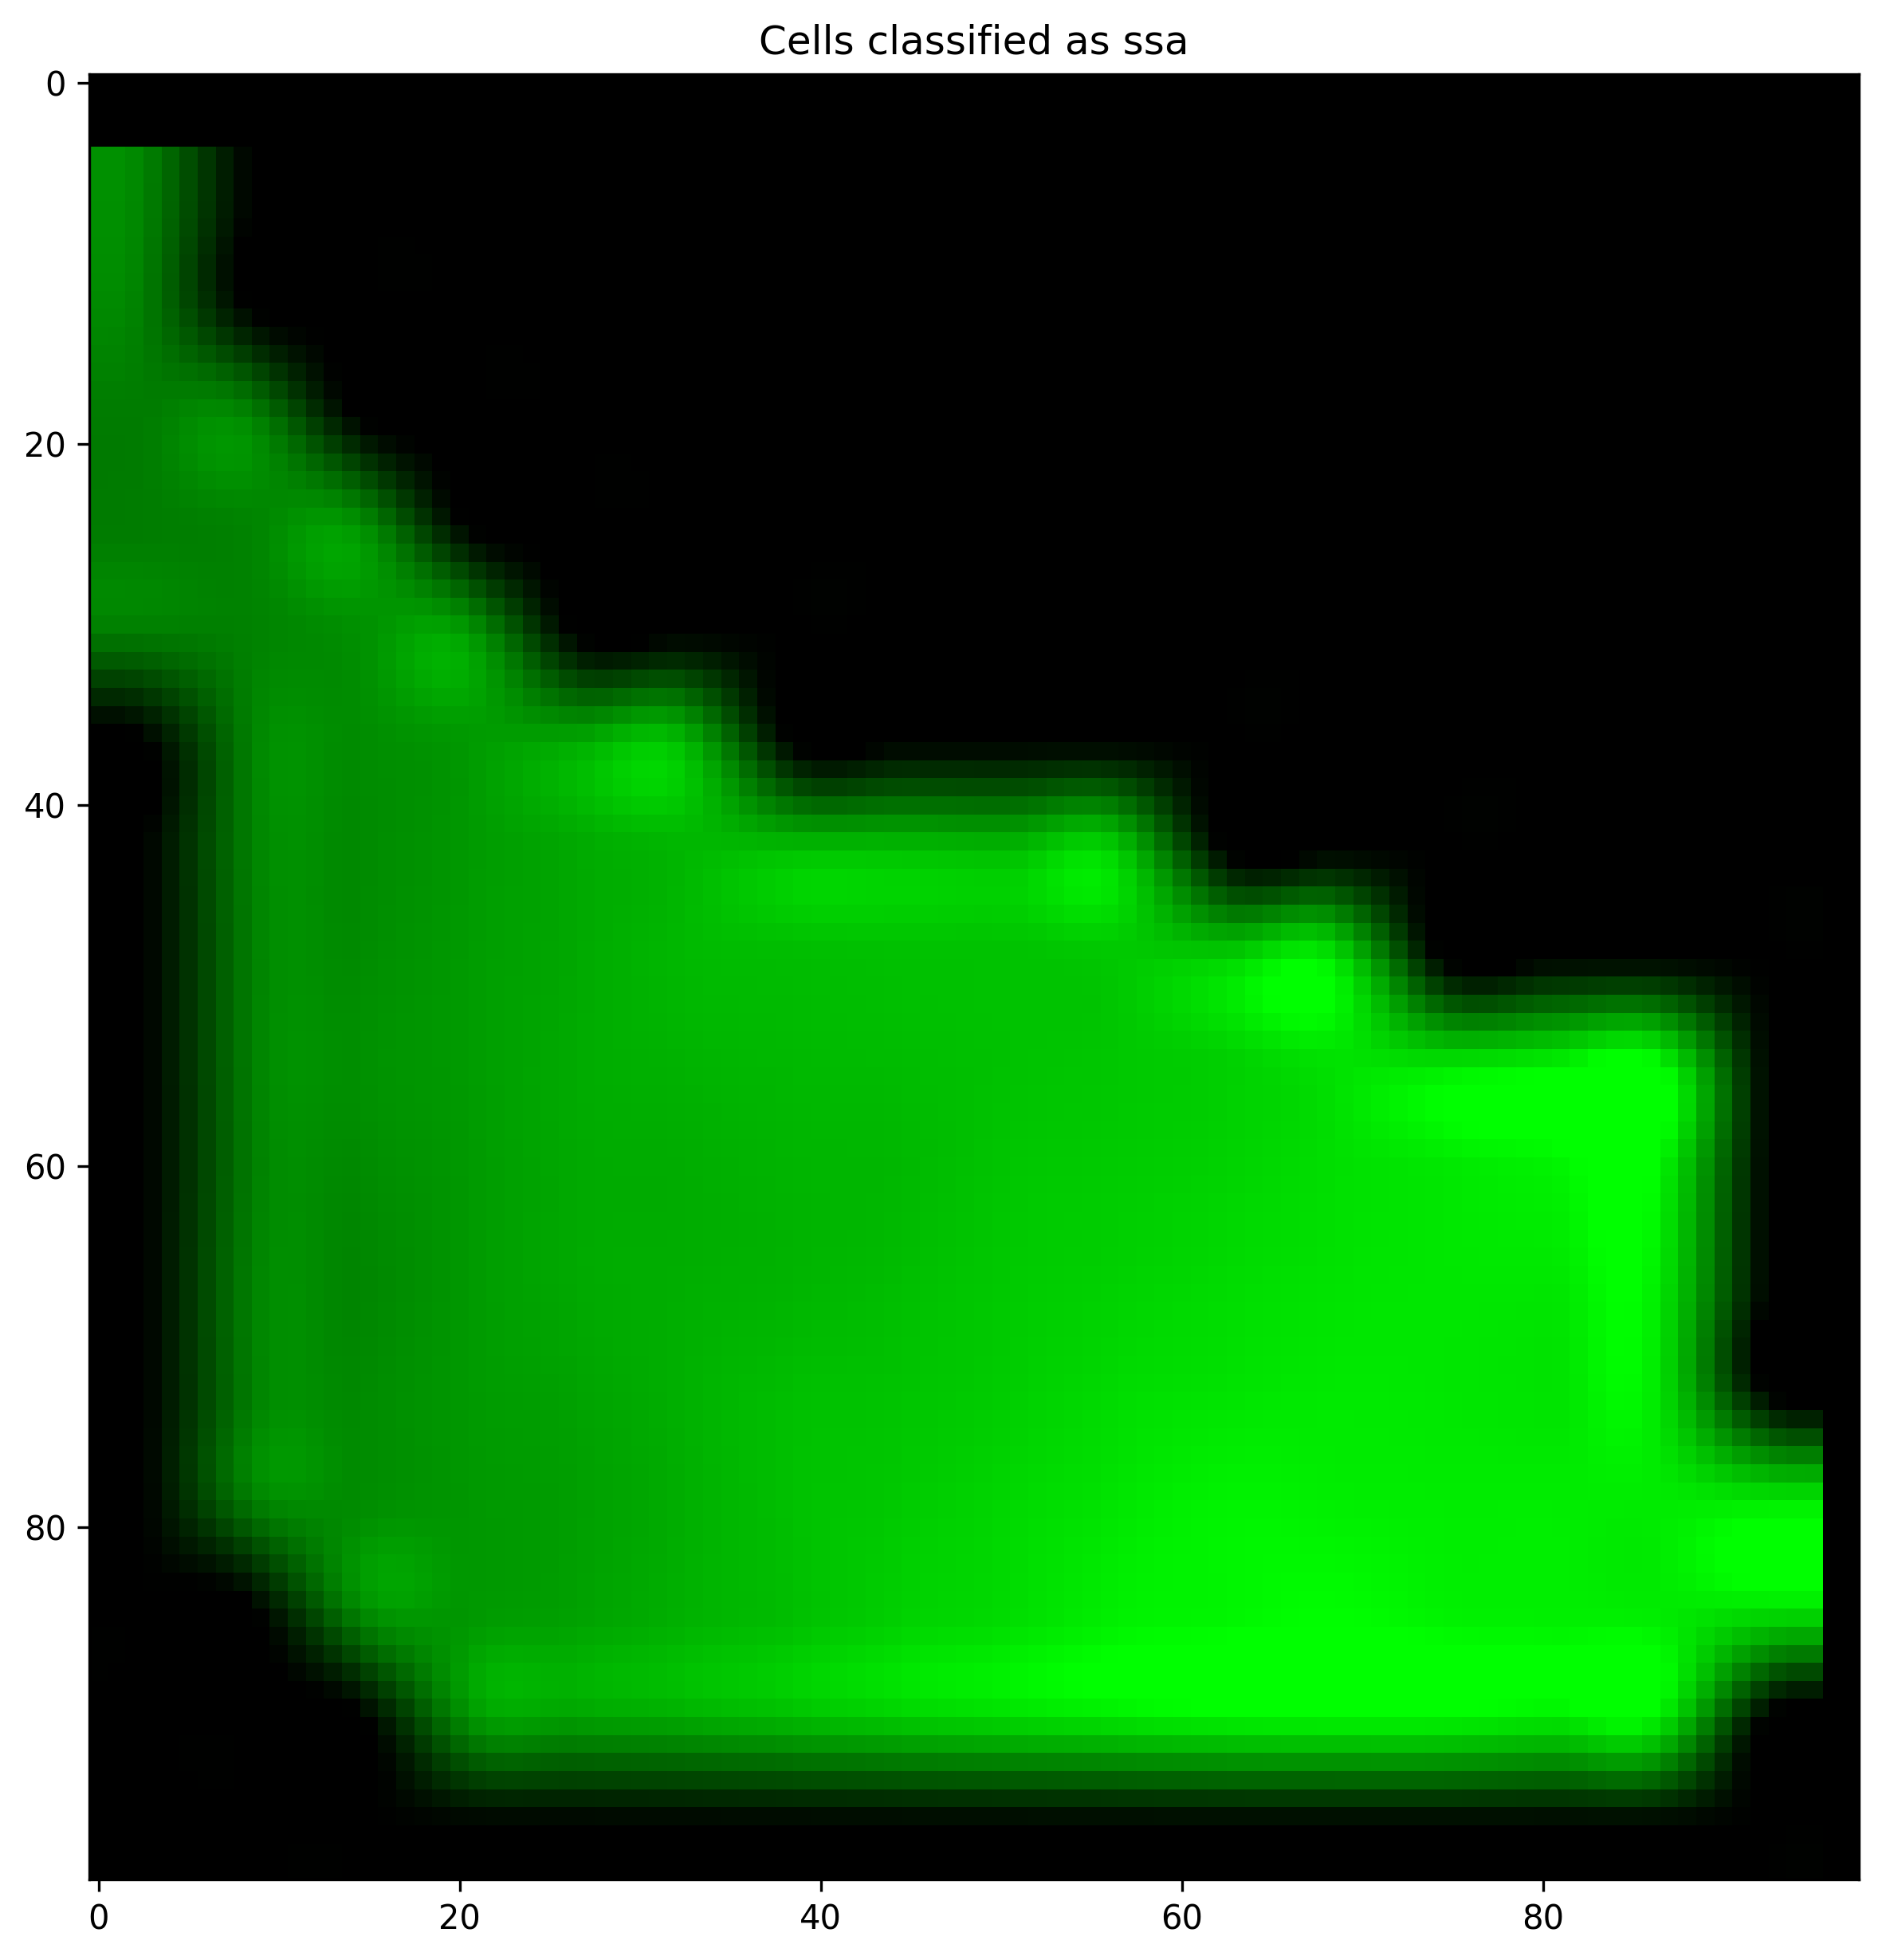

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 1


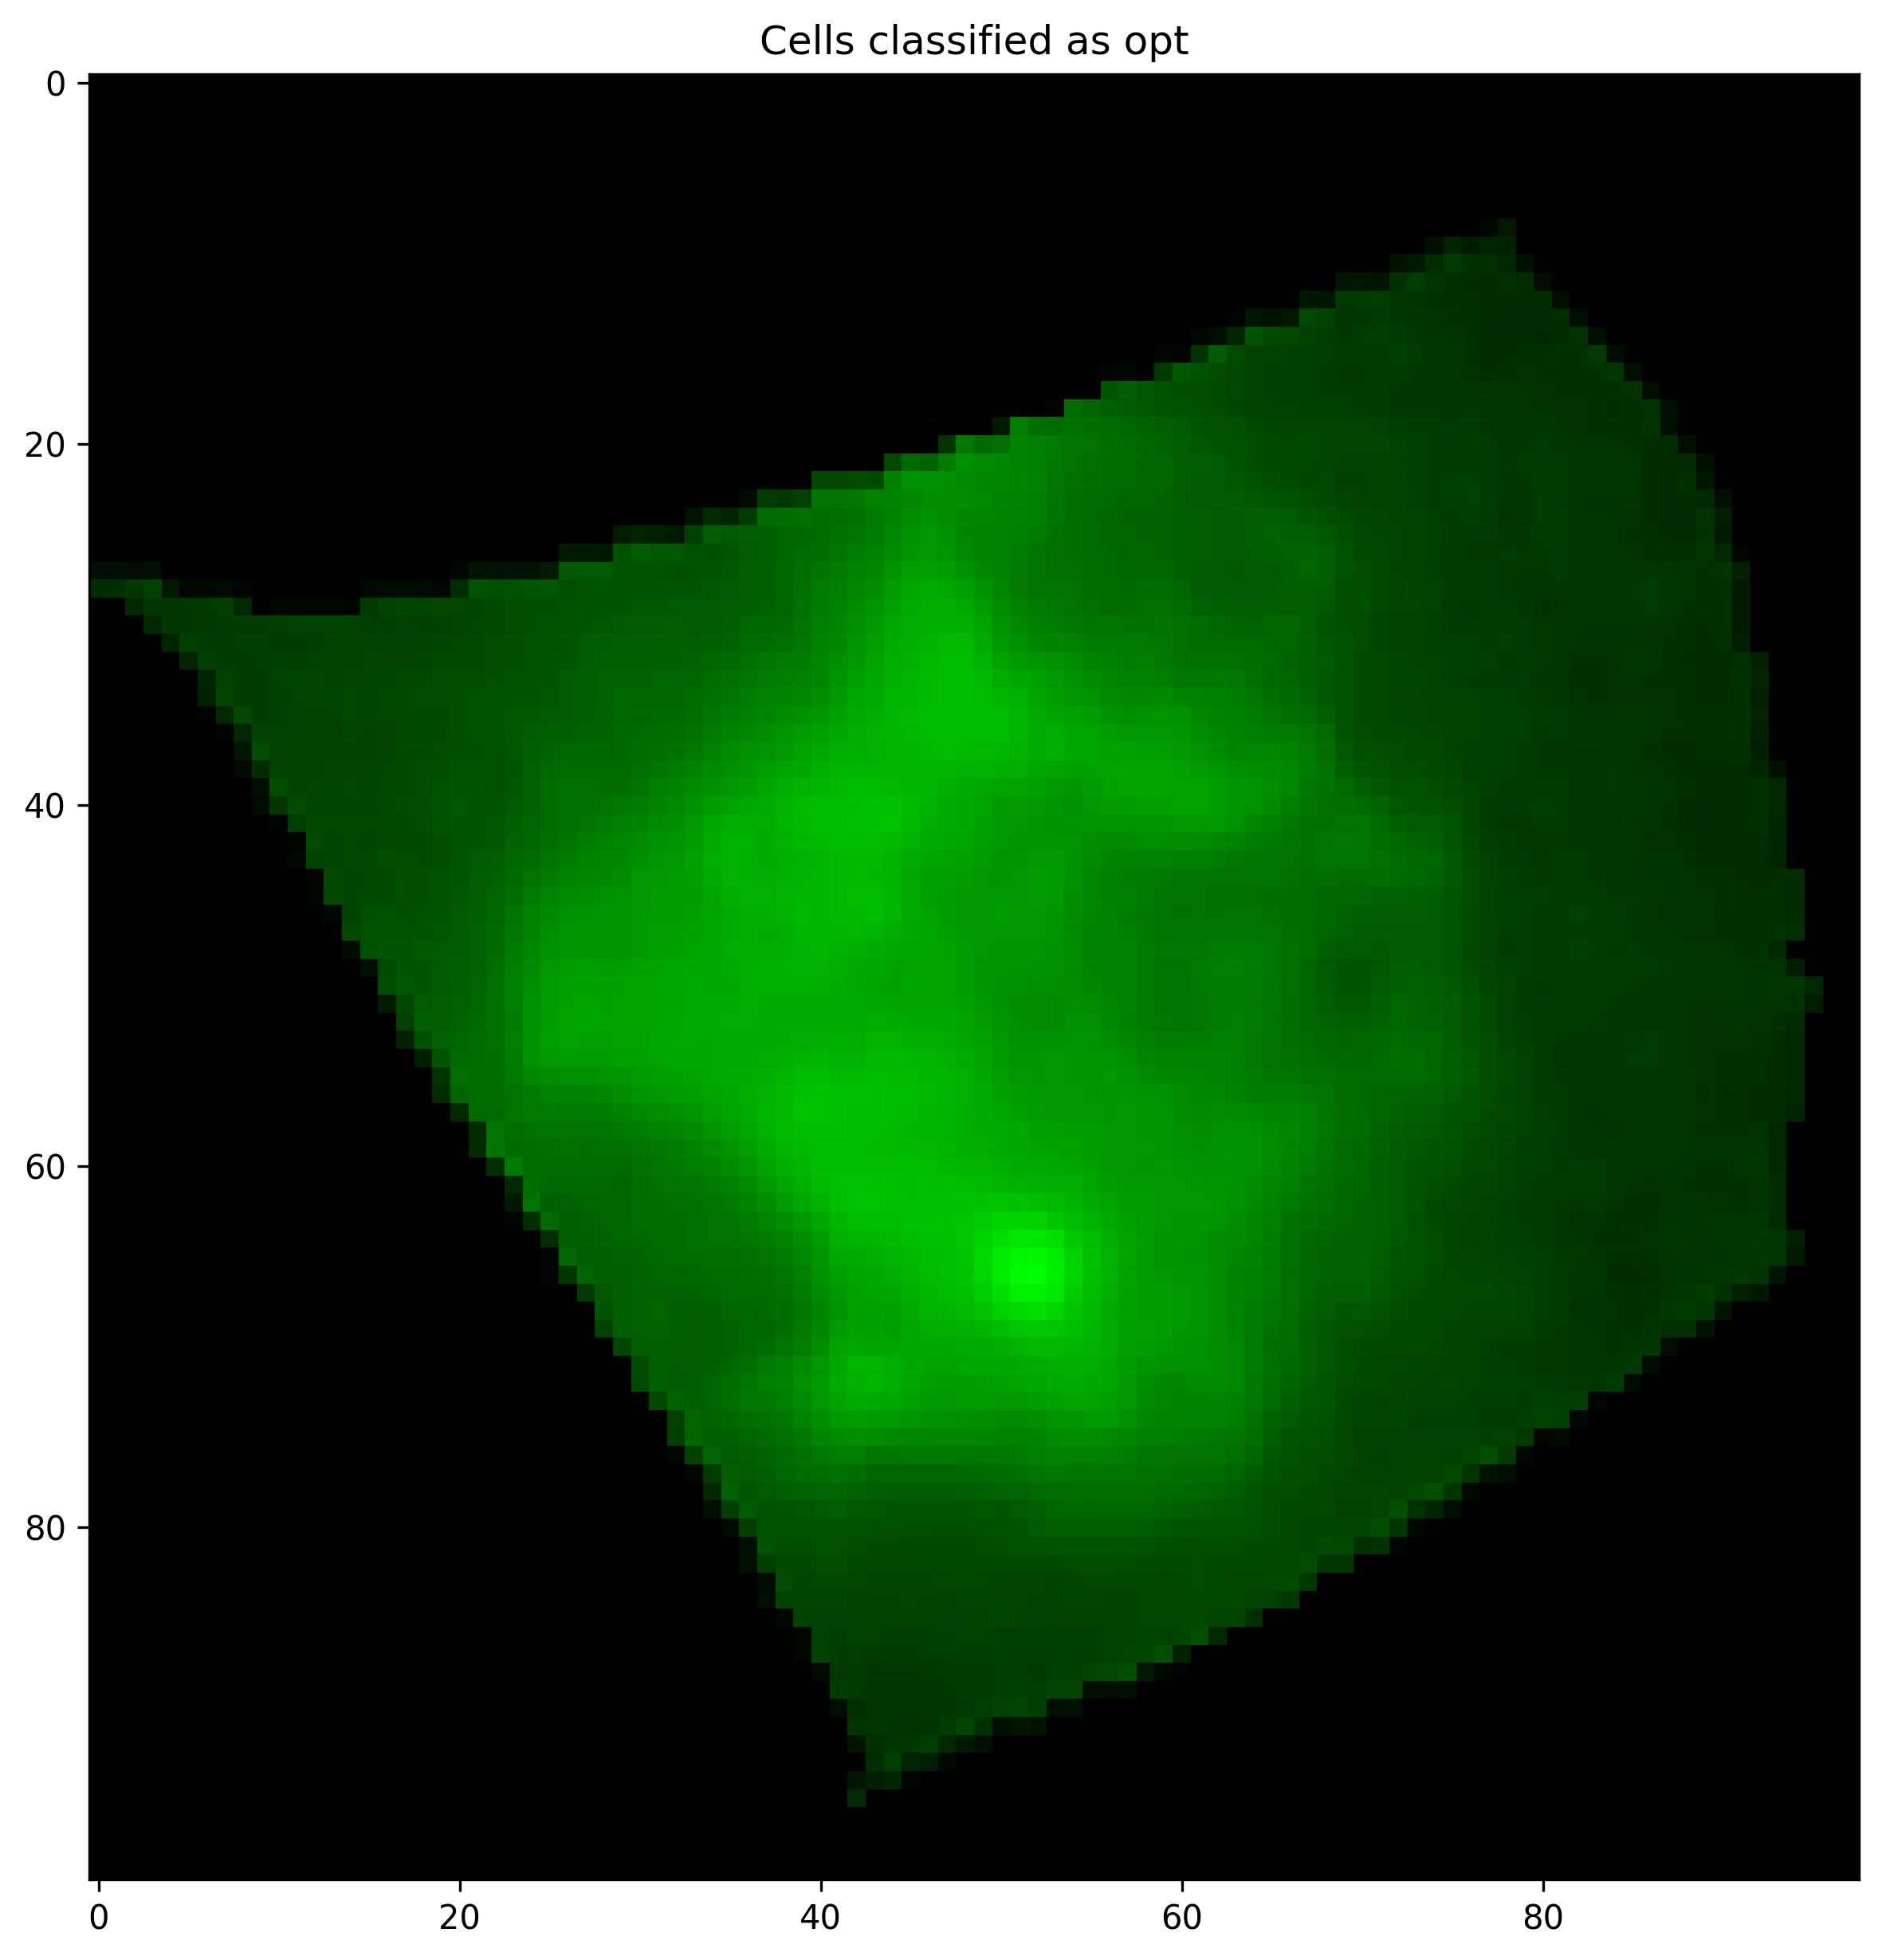

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 5


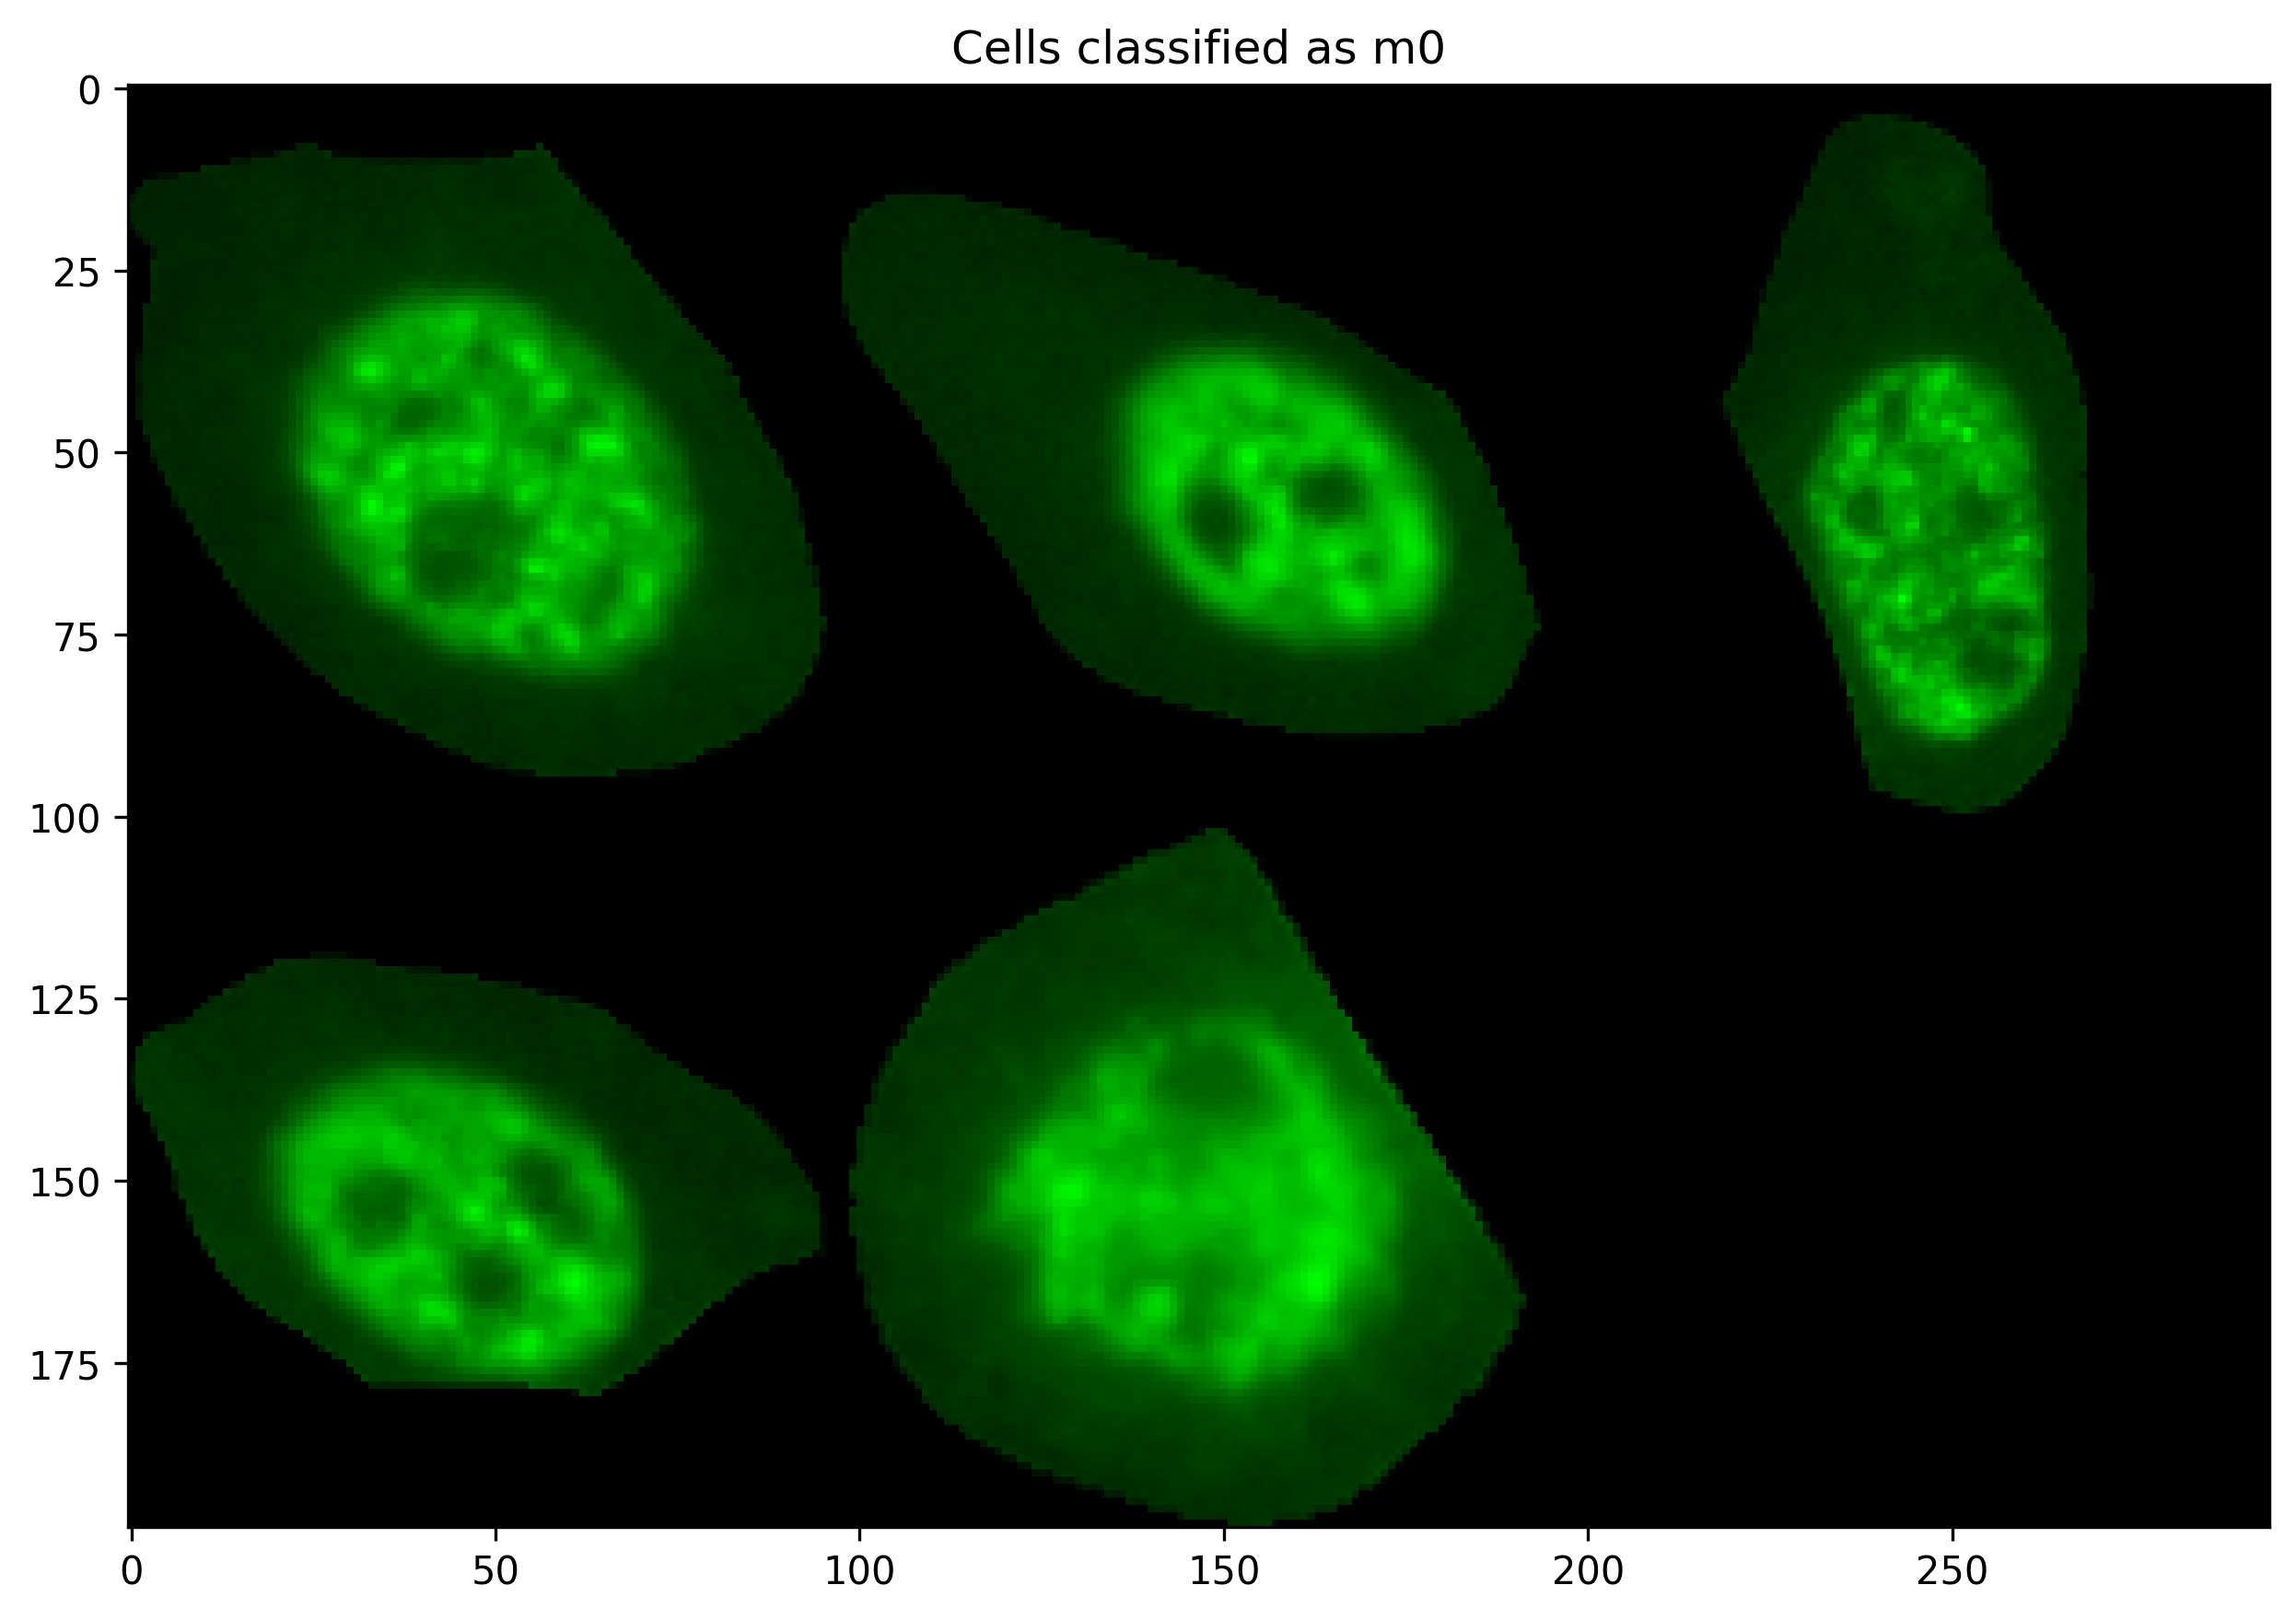

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 13


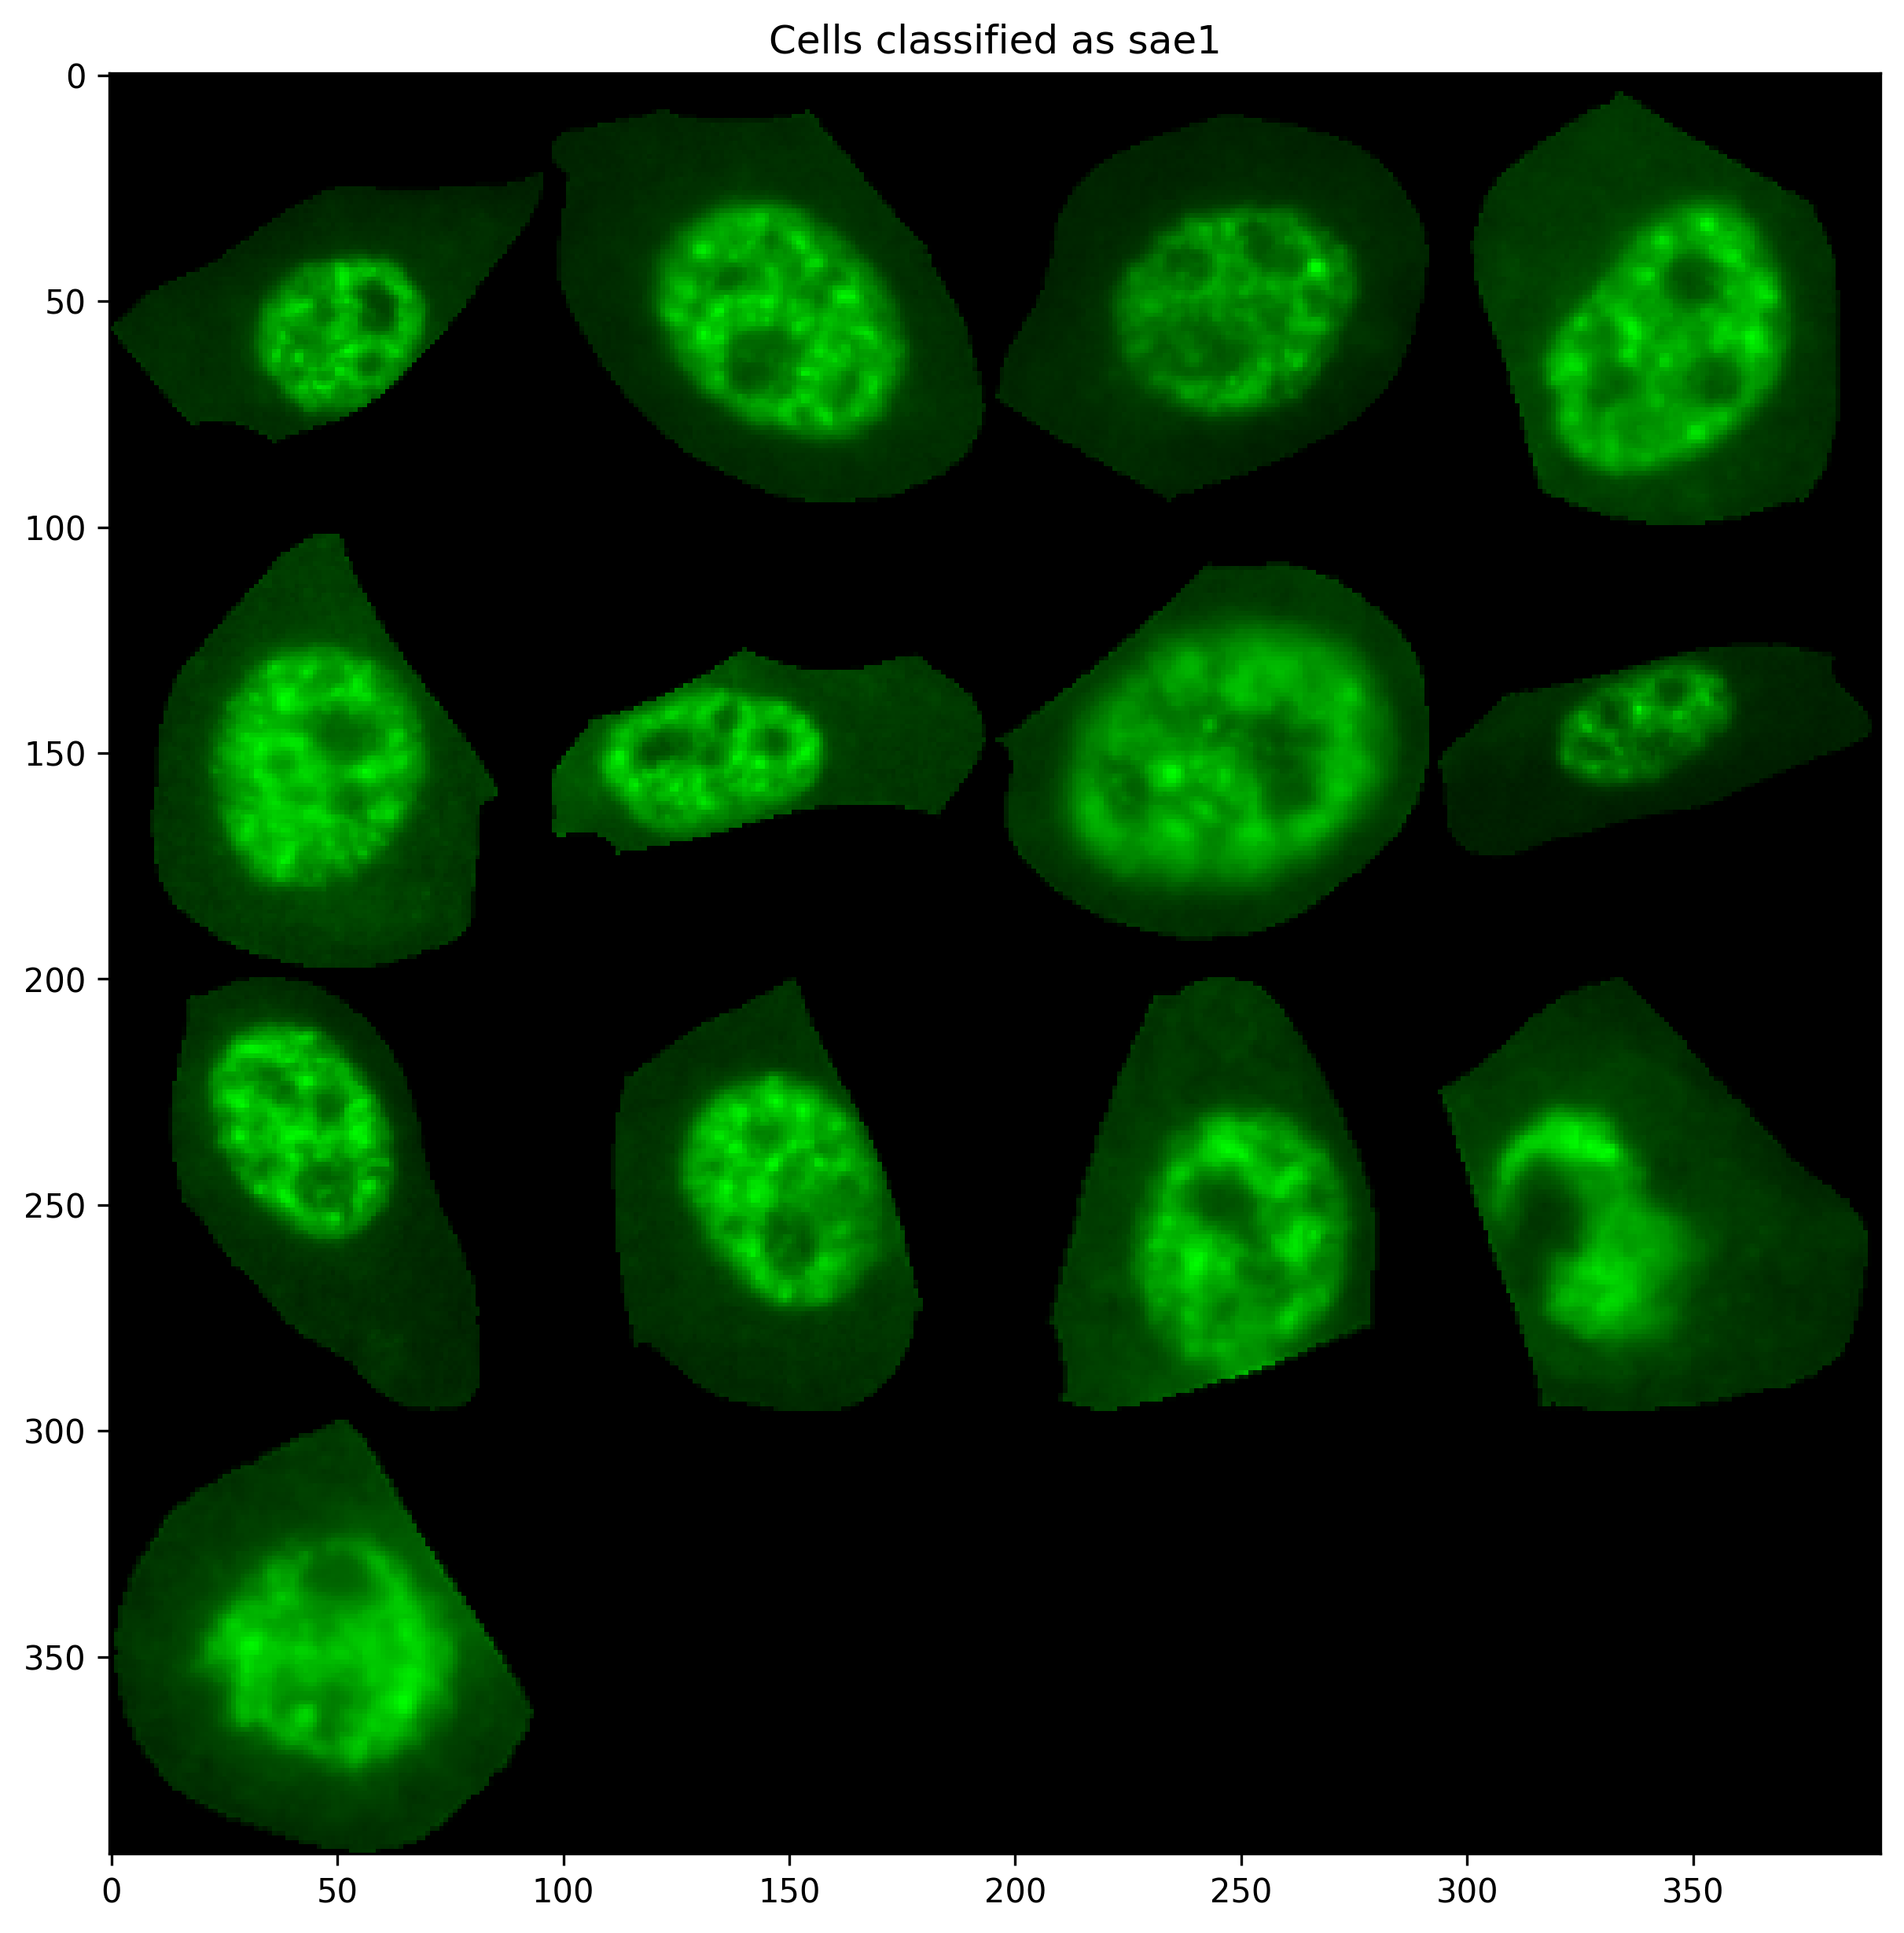

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of cells: 1


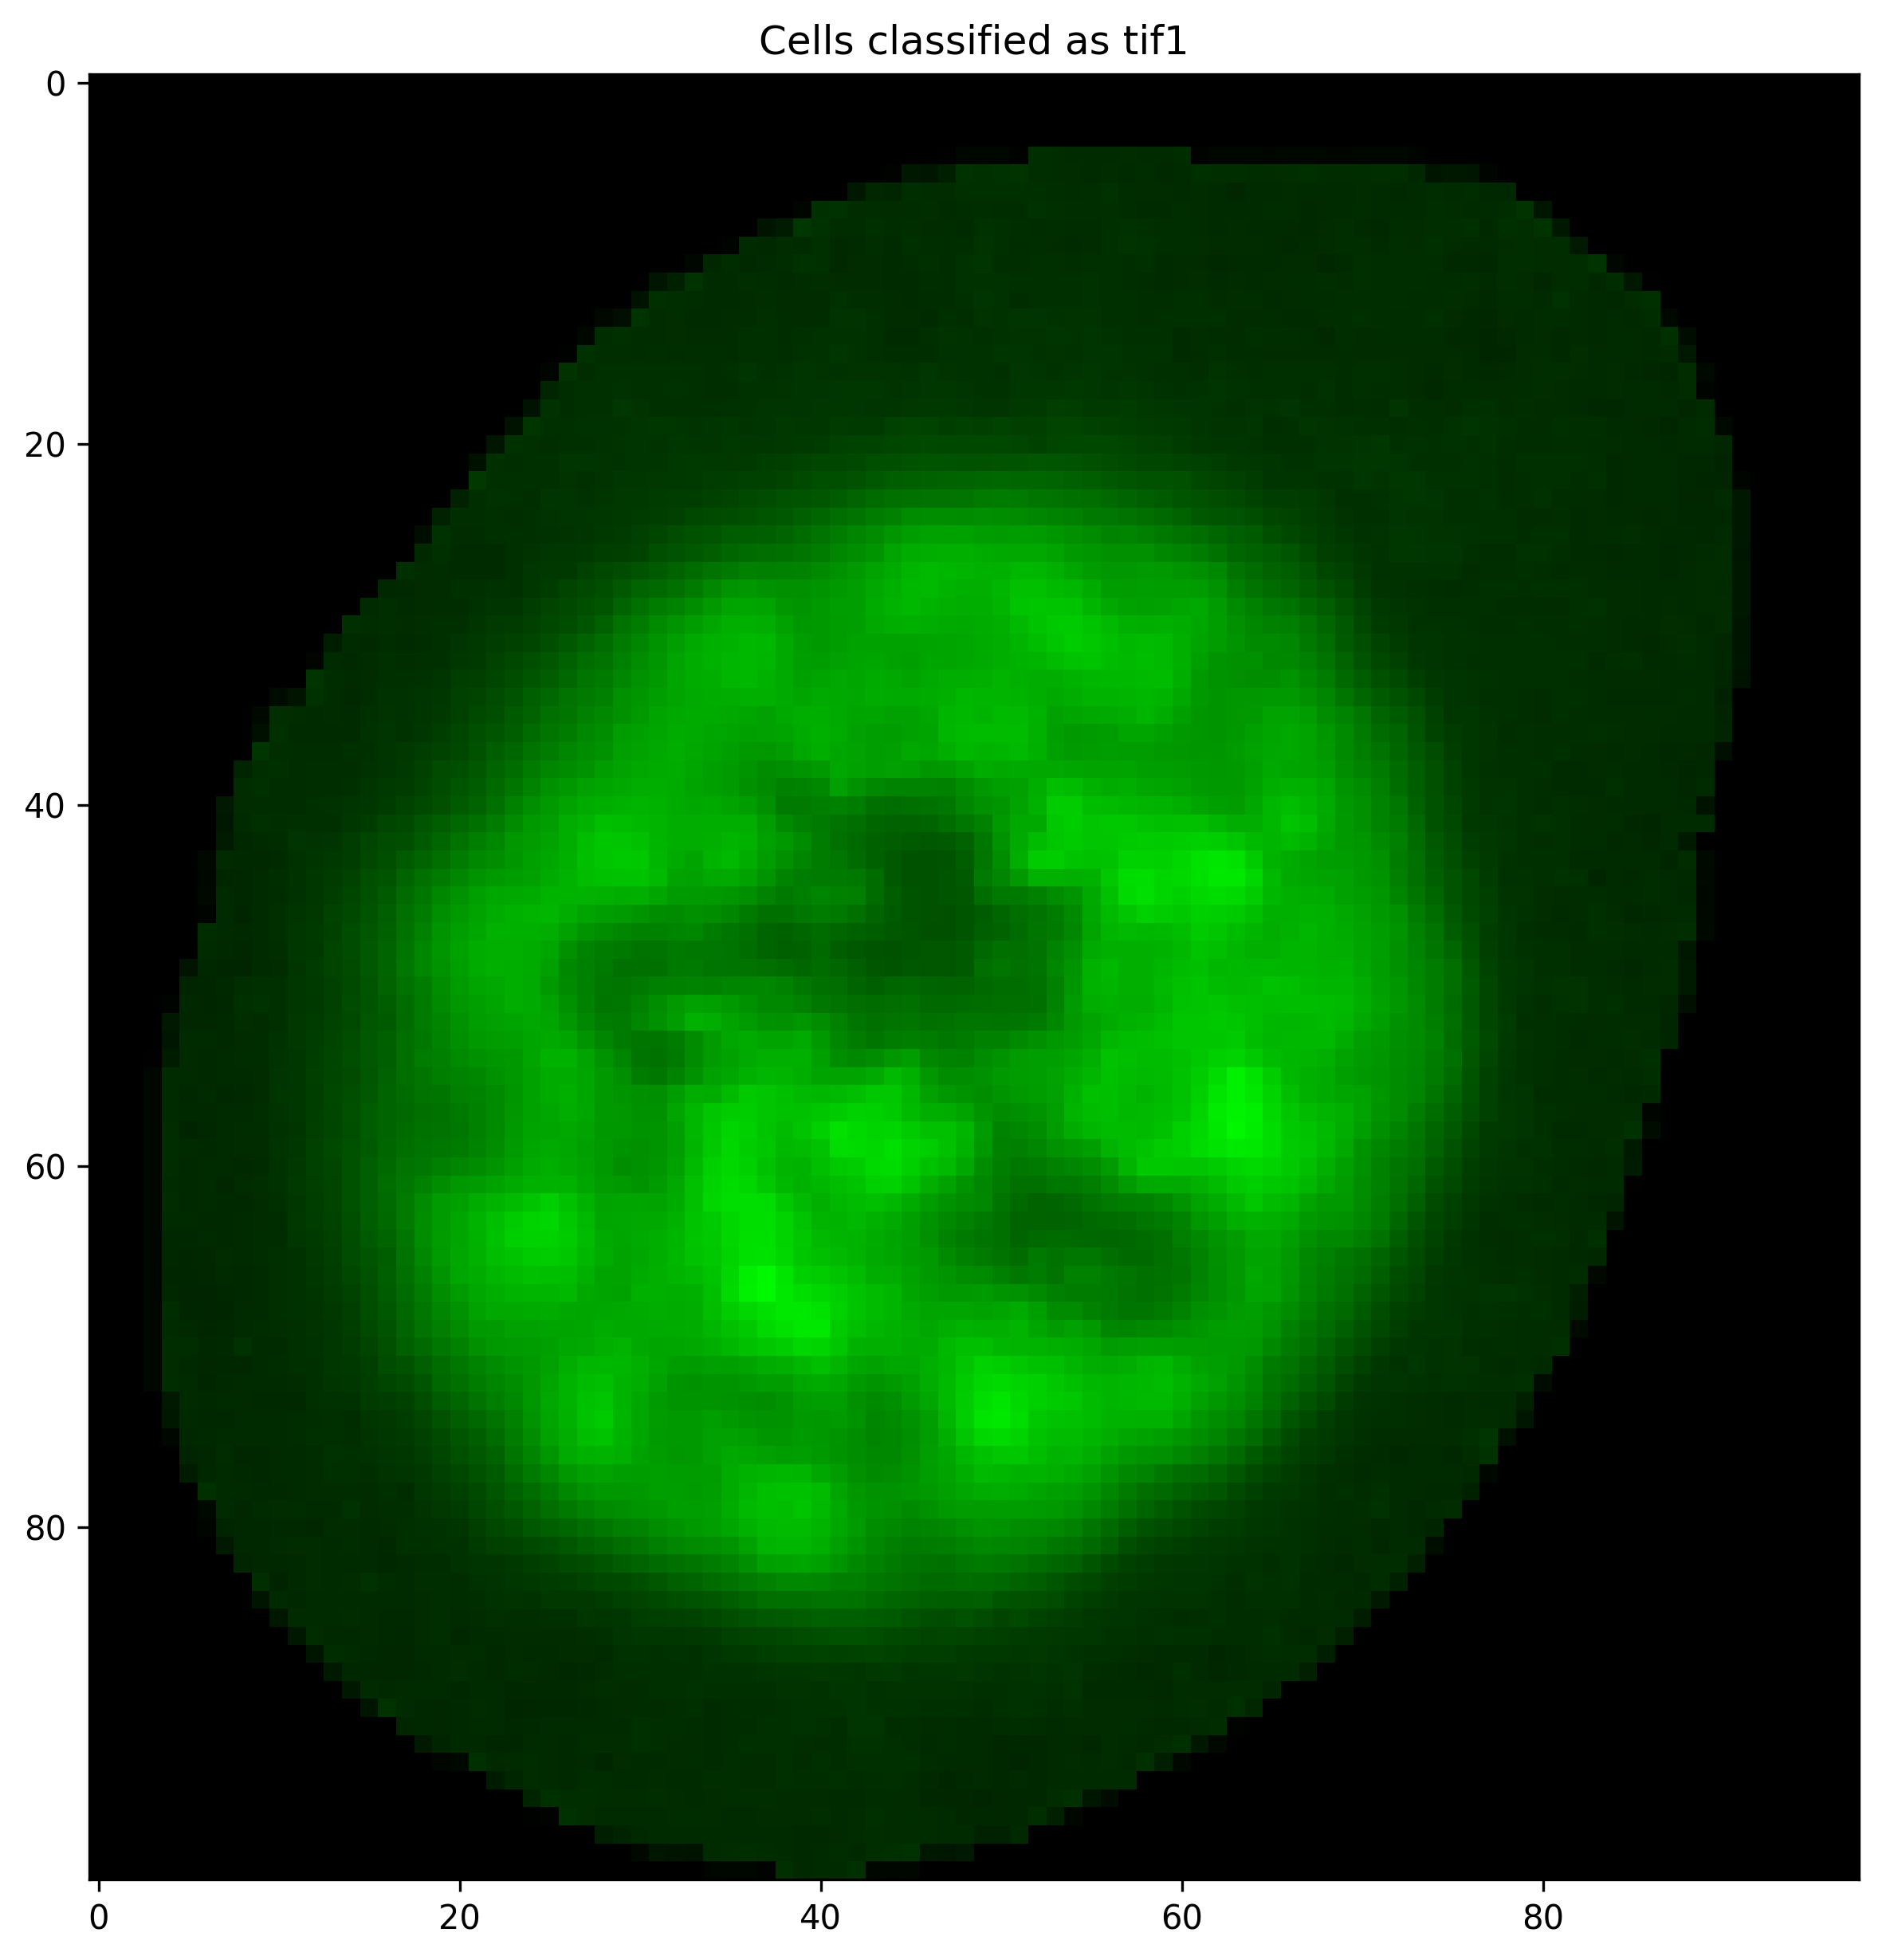

Top Predictions:
1 - mouchete

2 - sae1

3 - m0

4 - tif1

5 - ssa

6 - opt



In [36]:
print('Classifying')
classify_cells_label(square_filtered_cyto, n_primary_classes, weight_list, image_reshape_size, primary_classes)